In [1]:
from time import time
import logging
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn import datasets
import skimage
from skimage import io
import os
from skimage.transform import rescale, resize
from skimage.color import rgb2gray
import re
import random

D:\Anaconda\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [2]:
arr = os.listdir("D:\\APS360_Proj\\aligned_cropped_facescrub\\")
Y = []
for i in arr:
    list_temp = i.split(' ')
    Y.append(str(list_temp[0]+list_temp[1]))
y_set = set(Y)
list_to_operate = np.array(list(y_set))
y_idx = [(list_to_operate[i],i) for i in range(len(list_to_operate)) ]
y_dict = dict(y_idx)
y_ready = [y_dict.get(i) for i in Y]
y = np.array(y_ready)

In [3]:
path_all = "D:\\APS360_Proj\\aligned_cropped_facescrub\\*.jpg"

In [4]:
all_data = io.imread_collection(path_all)

In [5]:
all_data_processed = []
#resized_all = []

In [6]:
for i in range(len(all_data)):
    resized = resize(all_data[i], (all_data[i].shape[0]  *7, all_data[i].shape[1] *7,3),
                           anti_aliasing=True)
    #resized_all.append(resized)#Append resized RGB
    image_gray = rgb2gray(resized)
    all_data_processed.append(image_gray)
X = np.array(all_data_processed)#Gray_scale image for SVM


D:\Anaconda\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [7]:
# X_copy = np.array(X,copy =True)

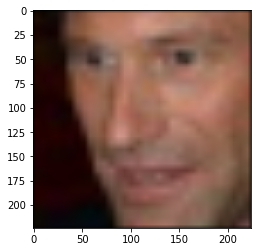

In [8]:
# plt.imshow(resized_all[1],cmap = 'gray')

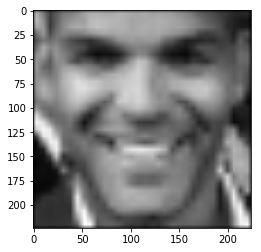

In [7]:
plt.imshow(X[1359],cmap = 'gray')

In [8]:
X= np.reshape(X,(X.shape[0],-1))

In [9]:
X.shape

(21759, 50176)

In [10]:
y.shape

(21759,)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

In [12]:
# #############################################################################
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 150
print("Extracting the top %d eigenfaces from %d faces"
      % (n_components, X_train.shape[0]))
t0 = time()
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, 224, 224)) #height and width

print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))

Extracting the top 150 eigenfaces from 16319 faces
done in 73.363s
Projecting the input data on the eigenfaces orthonormal basis
done in 27.495s


In [14]:
print("Fitting the classifier to the training set")
t0 = time()
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5], 
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], } 


clf = GridSearchCV(
    SVC(kernel='rbf', class_weight='balanced'), param_grid
)
clf = clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Fitting the classifier to the training set


D:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


done in 393.868s
Best estimator found by grid search:
SVC(C=100000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.005, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [15]:
print("Fitting the classifier to the training set")
t0 = time()
model = SVC(kernel='rbf', class_weight='balanced',C = 1e5, gamma = 0.005)
model.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print("Test score given by the estimator")
print(model.score(X_test_pca,y_test))

Fitting the classifier to the training set
done in 82.068s
Test score given by the estimator
0.6308823529411764


In [16]:
# #############################################################################
# Quantitative evaluation of the model quality on the test set

print("Predicting people's names on the test set")
t0 = time()
y_pred = model.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=list(y_set)))


Predicting people's names on the test set
done in 32.607s
                      precision    recall  f1-score   support

          EdiGathegi       0.73      0.88      0.80        25
            MattLong       0.61      0.69      0.65        16
         JeremyIrons       0.48      0.52      0.50        31
         AdrienBrody       0.74      0.76      0.75        33
        MarkWahlberg       0.51      0.62      0.56        32
           BillyZane       0.69      0.81      0.75        27
          ChrisEvans       0.50      0.55      0.52        22
        IoanGruffudd       0.74      0.71      0.73        28
      DermotMulroney       0.88      0.70      0.78        30
        HarrisonFord       0.75      0.33      0.46        18
     MiloVentimiglia       0.54      0.54      0.54        41
       DustinHoffman       0.51      0.68      0.58        31
           ChrisRock       0.92      0.92      0.92        25
     DominicMonaghan       0.62      0.59      0.60        27
           

In [17]:
print(confusion_matrix(y_test, y_pred, labels=range(len(y_set))))

[[22  0  0 ...  0  0  0]
 [ 0 11  0 ...  0  0  0]
 [ 0  0 16 ...  0  0  0]
 ...
 [ 0  0  0 ... 18  0  0]
 [ 0  0  0 ...  0 12  0]
 [ 0  0  0 ...  0  0 21]]


In [18]:
# #############################################################################
# Qualitative evaluation of the predictions using matplotlib

def plot_gallery(images, titles, h, w, n_row=5, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(3 * n_col, 4.5 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())


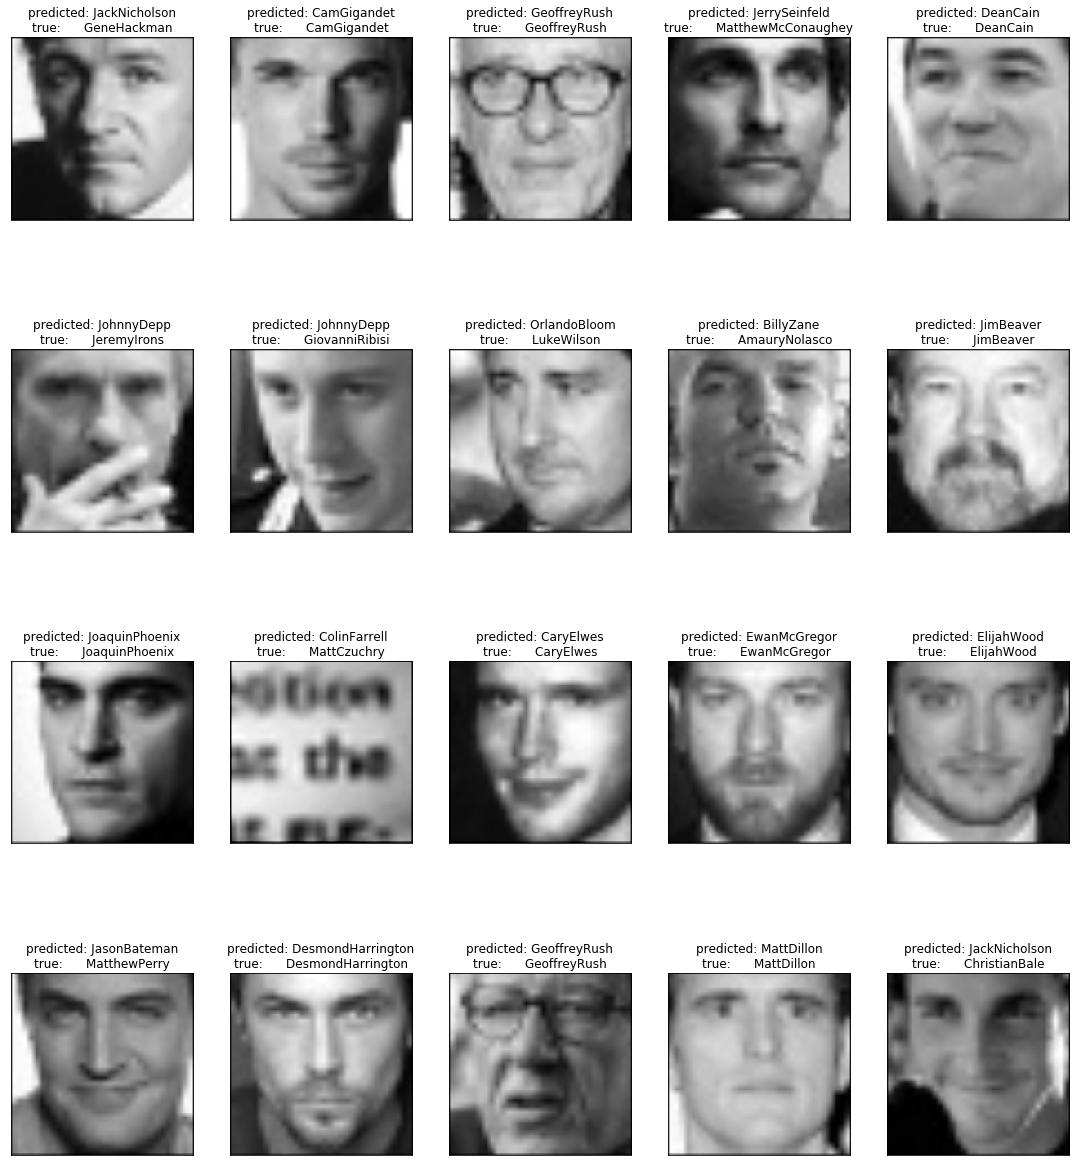

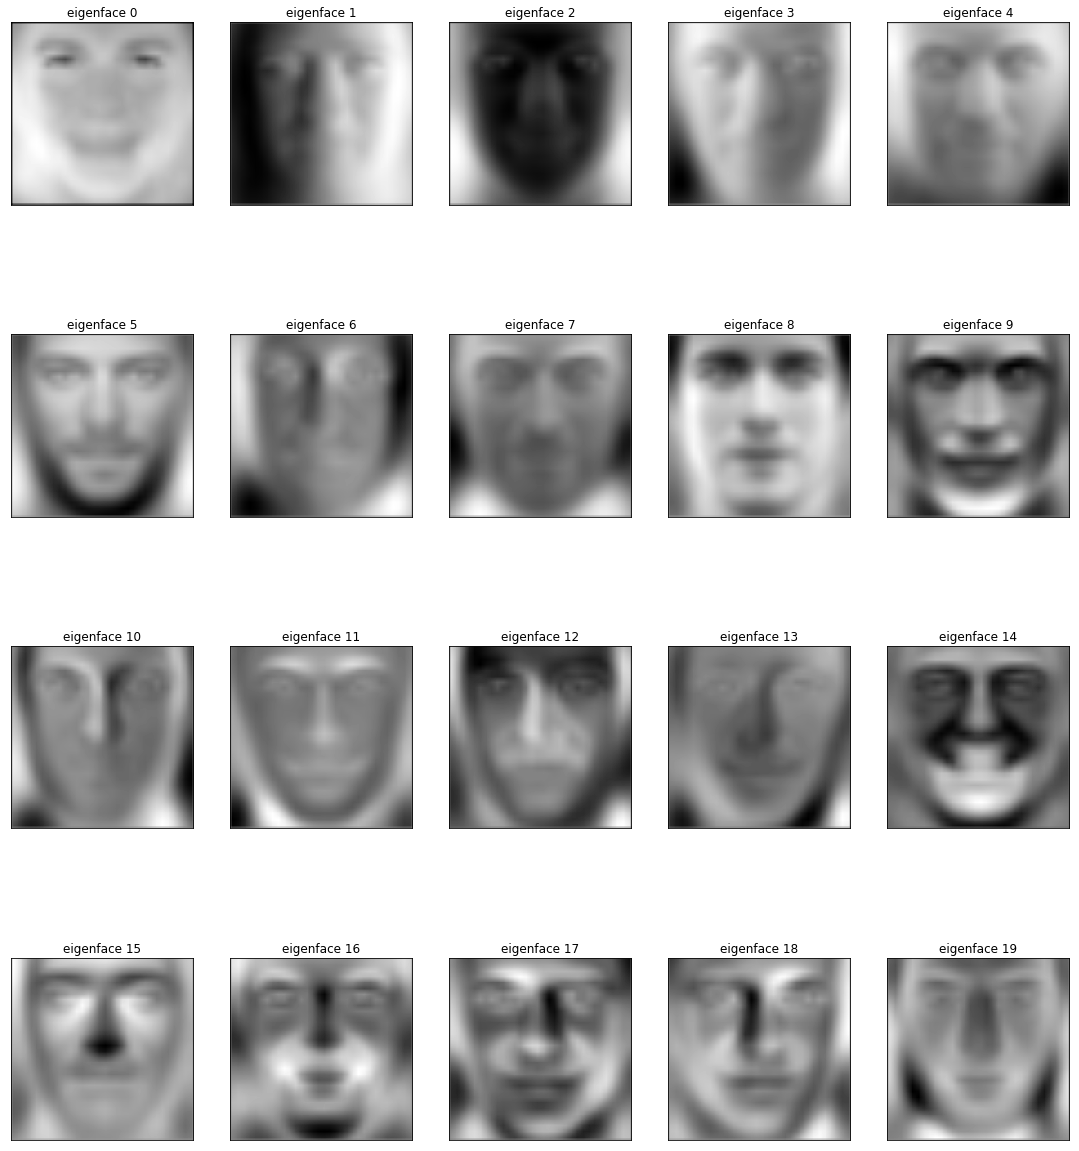

In [19]:
# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, list(y_set), i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, 224, 224,4,5)

# plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, 224, 224,4,5)

plt.show()

In [59]:
X= np.reshape(X,(X.shape[0],224,224))

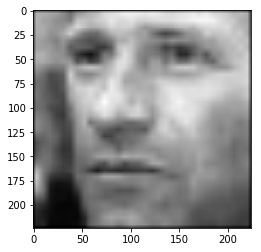

In [22]:
plt.imshow(X[0],cmap = 'gray')

In [29]:
length = len(X_test_pca)
new_index = np.random.permutation(length)
new_index

array([1081, 3746, 4130, ..., 2984, 2025, 4787])

In [30]:
X_test_pca_shuffled = X_test_pca[new_index]
y_test_shuffuled = y_test[new_index]

In [34]:
prediciton = model.predict(X_test_pca_shuffled)
count = 0
predict_tru = 0
actual_tru = 0
TT = 0
for i in range(0,len(X_test_pca_shuffled),2):
    predict_same = prediciton[i] == prediciton[i+1]
    actual_same = y_test_shuffuled[i]==y_test_shuffuled[i+1]
    if predict_same ==  actual_same:
        count+=1
    if actual_same:
        actual_tru+=1
    if predict_same:
        predict_tru +=1
    if actual_same and predict_same:
        TT+=1
            
            
        
Precision = TT/predict_tru
Recall = TT/actual_tru
print("Total correct cases = {}".format(count/i))
print("Precision score is {}".format(Precision))
print("Recall score is {}".format(Recall))
print("F1-score is {}".format((2*Precision*Recall)/(Precision+Recall)))

Total correct cases = 0.49797719749908054
Precision score is 0.5384615384615384
Recall score is 0.5384615384615384
F1-score is 0.5384615384615384


The below two pictures are the Same person


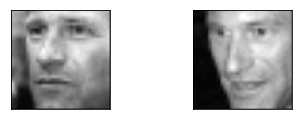

In [149]:
#print("Classification Visulization on Aaron Eckhart\n")
for i in range(2):
    #plt.figure(figsize=(6, 9))
    #plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90,hspace=.35)
    plt.subplot(2, 2, i + 1)
    plt.imshow(X_test_pca_shuffled[i].reshape((224, 224)), cmap=plt.cm.gray)
    
    
    if i % 2 !=0:
        same = "the Same person" if result[i-1]==result[i] else "Different people"
    #plt.title(same, size=12)    
    plt.xticks(())
    plt.yticks(())
print("The below two pictures are "+same)

In [60]:
X= np.reshape(X,(X.shape[0],-1))
X_pca = pca.transform(X)

In [64]:
X_pca[:1000].shape

(1000, 150)

In [65]:
result =  model.predict(X_pca[:1000])

The below two pictures are predicted to be the Same person
The below two pictures are actually the Same person
The model prediction is True


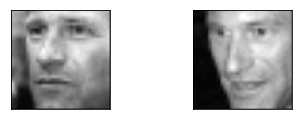

In [72]:
for i in range(2):
    #plt.figure(figsize=(6, 9))
    #plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90,hspace=.35)
    plt.subplot(2, 2, i + 1)
    plt.imshow(X[i].reshape((224, 224)), cmap=plt.cm.gray)
    
    
    if i % 2 !=0:
        same = "the Same person" if result[i-1]==result[i] else "Different people"
        actual = "the Same person" if y[i-1]==y[i] else "Different people"
    #plt.title(same, size=12)    
    plt.xticks(())
    plt.yticks(())
print("The below two pictures are predicted to be "+same)
print("The below two pictures are actually "+actual)
print("The model prediction is {}".format(actual == same))

The below two pictures are predicted to be Different people
The below two pictures are actually the Same person
The model prediction is False


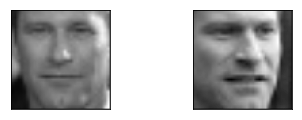

In [73]:
for i in range(2,4):
    #plt.figure(figsize=(6, 9))
    #plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90,hspace=.35)
    plt.subplot(2, 2, i + 1)
    plt.imshow(X[i].reshape((224, 224)), cmap=plt.cm.gray)
    
    
    if i % 2 !=0:
        same = "the Same person" if result[i-1]==result[i] else "Different people"
        actual = "the Same person" if y[i-1]==y[i] else "Different people"
    #plt.title(same, size=12)    
    plt.xticks(())
    plt.yticks(())
print("The below two pictures are predicted to be "+same)
print("The below two pictures are actually "+actual)
print("The model prediction is {}".format(actual == same))